<a href="https://colab.research.google.com/github/sefahw/AI-first-asignment/blob/master/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import numpy as np
import matplotlib.pyplot as plt


In [219]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 

In [220]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [221]:
print(x_train.shape
      )
print(x_test.shape)
print(x_train[0].dtype)

(60000, 28, 28)
(10000, 28, 28)
uint8


In [222]:
x_train=x_train.reshape(-1,784)
x_test=x_test.reshape(-1,784)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


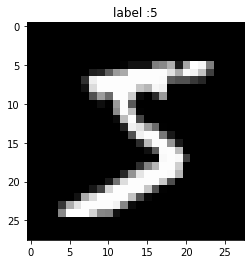

In [223]:
import matplotlib.pyplot as plt
%matplotlib inline
index=0
image=x_train[index].reshape(28,28)
plt.imshow(image,'gray')
plt.title('label :{}'.format(y_train[index]))
plt.show()

In [224]:
x_train=x_train.astype(np.float)
x_test=x_test.astype(np.float)
x_train/=255
x_test/=255
print(x_train.max())
print(x_test.min())

<ipython-input-224-faaf96f9f63a>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train=x_train.astype(np.float)


1.0
0.0


<ipython-input-224-faaf96f9f63a>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test=x_test.astype(np.float)


In [225]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2)
print(x_train.shape)
print(x_val.shape)

(48000, 784)
(12000, 784)


In [226]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train_one_hot =enc.fit_transform(y_train[:,np.newaxis])
y_val_one_hot=enc.transform(y_val[:,np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape)
print(y_train_one_hot.dtype)

(48000,)
(48000, 10)
float64


In [227]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [228]:
get_mini_batch = GetMiniBatch(x_train, y_train, batch_size=20)

print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_x_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([3, 6, 2, 5, 3, 5, 5, 4, 9, 6, 1, 8, 5, 7, 0, 0, 5, 0, 1, 9],
      dtype=uint8))


<ipython-input-227-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


In [229]:
class ScratchSimpleNeuralNetrowkClassifier():
   

    def __init__(self,epoch=50,n_features=784,n_nodes1=400,n_nodes2=200,n_output=10,sigma=0.01,n_batch=20,activate_function_key='tanh',lr=0.01, verbose = False):
        self.n_epoch=epoch
        self.n_features=n_features
        self.n_nodes1=n_nodes1
        self.n_nodes2=n_nodes2
        self.n_output=n_output
        self.sigma=sigma
        self.n_batch=n_batch
        self.activate_function_key=activate_function_key
        self.lr=lr
        self.verbose = verbose

    
    def initial_weight(self):
        self.w1=self.sigma*np.random.randn(self.n_features,self.n_nodes1)
        self.b1=np.zeros(self.n_nodes1)
        self.w2=self.sigma*np.random.randn(self.n_nodes1,self.n_nodes2)
        self.b2=np.zeros(self.n_nodes2)
        self.w3=self.sigma*np.random.randn(self.n_nodes2,self.n_output)
        self.b3=np.zeros(self.n_output)

    def activation_function(self,x):
        if self.activate_function_key=='sigmoid':
            return 1/(1+np.exp(-x))
        elif self.activate_function_key=='tanh':
            return np.tanh(x)    
    def softmax(self,x):
         return np.exp(x-np.max(x))/np.sum(np.exp(x-np.max(x)),axis=1, keepdims=True)
    def loss_function(self,y,yt):
        delta=1e-7
        return -np.mean(yt*np.log(y+delta))
    def gradient_descent(self,x,y,yt):
        delta_a3=(y-yt)/self.n_batch
        delta_b3=np.sum(delta_a3,axis=0)
        delta_w3=np.dot(self.z2.T,delta_a3)
        delta_z2=np.dot(delta_a3,self.w3.T)
        self.w3=self.lr*delta_w3
        self.b3=self.lr*delta_b3
        if self.activate_function_key=='sigmoid':
           delta_a2=delta_z2*(1-self.activation_function(self.z2))*self.activation_function(self.z2)
        elif self.activate_function_key=='tanh':
             delta_a2=delta_z2*(1-np.tanh(self.z2)**2)
        delta_b2=np.sum(delta_a2,axis=0)
        delta_w2=np.dot(self.z1.T,delta_a2)
        delta_z1=np.dot(delta_a2,self.w2.T)
        self.w2-=self.lr*delta_w2
        self.b2-=self.lr*delta_b2
        if self.activate_function_key=='sigmoid':
           delta_a1=delta_z1*(1-self.activation_function(self.z1))*self.activation_function(self.z1)
        elif self.activate_function_key=='tanh':
             delta_a1=delta_z1*(1-np.tanh(self.z1)**2)
        delta_b1=sum(delta_a1,axis=0)
        delta_w1=np.dot(x.T,delta_a1)
        self.w1-=self.lr*delta_w1
        self.b1-=self.lr*delta_b1
        

    def fit(self, x, y, x_val=False, y_val=False):
        self.initial_weight()
        self.log_loss=[]
        self.log_loss_val=[]
        self.log_acc=[]
        self.log_acc_val=[]
        for epoch in range (self.n_epoch):
            get_mini_batch=GetMiniBatch(x,y,batch_size=self.n_batch)
            self.loss=0
            self.true_y=np.array([])
            self.pred_y=np.array([])
        for mini_x_train,mini_y_train,in get_mini_batch:
            self.z1=self.activation_function(np.dot(mini_x_train,self.w1)+self.b1)
            self.z2=self.activation_function(np.dot(self.z1,self.w2)+self.b2)
            yhat=self.softmax(np.dot(self.z1,self.w2)+self.b2)
            self.gradient_descent(mini_x_train,yhat,mini_y_train)
            self.true_y=np.concatenate([self.true_y,np.argmax(mini_y_train,axis=1)])
            self.pred_y=np.concatenate([self.pred_y,np.argmax(yhat,axis=1)])
            self.loss+=self.loss_function(yhat,mini_y_train)
        self.log_loss.append(self.loss/len(get_mini_batch))
        acc=accuracy_score(self.true_y,self.pred_y)
        self.log_acc.append(acc)
        if (type(x_val)!=bool):
           self.z1_val=self.activation_function(np.dot(x_val,self.w1)+self.b1)
           self.z2_val=self.activation_function(np.dot(self.z1_val,self.w2)+self.b2)
           yhat_val=self.softmax_val(np.dot(self.z2_val,self.w3)+self.b3)
           self.loss_val=self.loss_function(yhat_val,y_val)
           self.log_loss_val.append(self.loss.val)
           acc_val=accuracy_score(np.argmax(y_val,axis=1),np.argmax(yhat_val,axis=1))
           self.log_acc_val.append(acc_val)

        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print('epoch:{:>3} loss:{:>8,.3f} acc:{:>5,.3f}',format(epoch,self.loss/self.n_batch,acc))
      

    def predict(self, x):
        self.pred_z1=self.activation_function(np.dot(x,self.w1)+self.b1)
        self.pred_z2=self.activation_function(np.dot(self.pred_z1,self.w2)+self.b2)
        return np.argmax(np.dot(self.pred_z2,self.w3)+self.b3,axis=1)
       

      

In [230]:
import numpy as np
n_features=784
n_nodes1=400
n_nodes2=200
n_outputs=10
sigma=0.01
w1=sigma*np.random.randn(n_features,n_nodes1)
print('w1',w1.shape)

w1 (784, 400)


In [231]:
w1=sigma*np.random.randn(n_features,n_nodes1)
b1=sigma*np.random.randn(n_nodes1)
w2=sigma*np.random.randn(n_nodes1,n_nodes2)
b2=sigma*np.random.randn(n_nodes2)
w3=sigma*np.random.randn(n_nodes2,n_outputs)
b3=sigma*np.random.randn(n_outputs)
print('w1',w1.shape)
print('b1',b1.shape)
print('w2',w2.shape)
print('b2',b2.shape)
print('w3',w3.shape)
print('b3',b3.shape)

w1 (784, 400)
b1 (400,)
w2 (400, 200)
b2 (200,)
w3 (200, 10)
b3 (10,)


In [232]:
x=x_train[0:20]

In [233]:
z1 = np.dot(x,w1)# + b1
print('z1.shape:',z1.shape)
print(z1)

z1.shape: (20, 400)
[[-0.00258219  0.13044827  0.03607458 ... -0.02016919 -0.03153315
  -0.04668789]
 [-0.01852437  0.06988484  0.02656873 ... -0.02492651  0.04428645
   0.01562639]
 [ 0.1980895   0.25514992  0.06085261 ...  0.06886187 -0.07260721
   0.07722739]
 ...
 [-0.01095391  0.11343303  0.06140305 ...  0.00196706 -0.01805703
  -0.12643677]
 [-0.029333    0.09415774  0.00379065 ... -0.00531439  0.01625164
  -0.00104318]
 [ 0.00749906  0.05401022  0.08321287 ...  0.00752869  0.01001492
  -0.07318581]]


In [234]:
sig1 = 1/(1+np.exp(-z1))
print('sig1.shape:',sig1.shape)
print(sig1)

sig1.shape: (20, 400)
[[0.49935445 0.5325659  0.50901767 ... 0.49495787 0.49211736 0.48833015]
 [0.49536904 0.5174641  0.50664179 ... 0.4937687  0.5110698  0.50390652]
 [0.54936107 0.56344366 0.51520846 ... 0.51720867 0.48185617 0.51929726]
 ...
 [0.49726155 0.52832789 0.51534594 ... 0.50049176 0.49548586 0.46843285]
 [0.49266728 0.52352206 0.50094766 ... 0.49867141 0.50406282 0.49973921]
 [0.50187476 0.51349927 0.52079122 ... 0.50188216 0.50250371 0.48171171]]


In [235]:
z2=np.dot(sig1,w2)+b2
print('z2.shape',z2.shape)
print(z2)

z2.shape (20, 200)
[[-0.06570852  0.07368384 -0.05497518 ... -0.0616947   0.03864852
   0.03720554]
 [-0.06254546  0.07506537 -0.05506448 ... -0.06891588  0.03589891
   0.03284738]
 [-0.06603312  0.07058879 -0.05309495 ... -0.07079386  0.03512294
   0.03638953]
 ...
 [-0.05626955  0.07627856 -0.04927466 ... -0.06947392  0.0387972
   0.03824626]
 [-0.0639787   0.07641486 -0.05191283 ... -0.06453824  0.03788727
   0.03279269]
 [-0.06119872  0.07807944 -0.05736954 ... -0.07121794  0.03757022
   0.03369292]]


In [236]:
sig2 = 1/(1+np.exp(-z2))
print('sig2.shape:',sig2.shape)
print(sig2)

sig2.shape: (20, 200)
[[0.48357878 0.51841263 0.48625967 ... 0.48458121 0.50966093 0.50930031]
 [0.48436873 0.51875754 0.48623736 ... 0.48277785 0.50897376 0.50821111]
 [0.48349772 0.51763987 0.48672938 ... 0.48230892 0.50877983 0.50909638]
 ...
 [0.48593632 0.5190604  0.48768383 ... 0.4826385  0.50969808 0.5095604 ]
 [0.48401078 0.51909442 0.48702471 ... 0.48387104 0.50947068 0.50819744]
 [0.48470509 0.51950995 0.48566155 ... 0.48220304 0.50939145 0.50842243]]


In [237]:
z3=np.dot(sig2,w3)+b3
print('z3.shape',z3.shape)
print(z3)

z3.shape (20, 10)
[[-0.03834024 -0.07057829 -0.02061837  0.06687463  0.15802824 -0.22309187
   0.0059607  -0.02615374  0.0537074  -0.1322205 ]
 [-0.03837165 -0.07045042 -0.02070861  0.06673314  0.15787425 -0.22296348
   0.00601453 -0.02621859  0.05380451 -0.13215121]
 [-0.0383159  -0.07045173 -0.02058949  0.06677404  0.15815284 -0.22282039
   0.00614303 -0.0262251   0.05396329 -0.13209967]
 [-0.03815642 -0.07069351 -0.02067426  0.06659713  0.15809844 -0.22300515
   0.00621832 -0.02619941  0.05397124 -0.13206087]
 [-0.0383443  -0.07055924 -0.02089263  0.06687735  0.15807987 -0.22284714
   0.0059394  -0.02611454  0.05393804 -0.13209954]
 [-0.03837438 -0.07045438 -0.02082956  0.06676738  0.15827805 -0.22317769
   0.00578552 -0.02618845  0.05390429 -0.13237781]
 [-0.03811621 -0.07044591 -0.02108368  0.06659578  0.15792971 -0.22294675
   0.0057828  -0.02610462  0.05389353 -0.13223358]
 [-0.03836746 -0.0704265  -0.02088996  0.06684792  0.15810804 -0.22308379
   0.00592773 -0.02618711  0.0538

In [238]:
sfmax=np.zeros([len(x),10])
for i in range(20):
    sfmax[i]=np.exp(z3[i])/np.sum(np.exp(z3[i]),axis=0)
print('sfmax.shape',sfmax.shape)
print(sfmax) 
print(np.sum(sfmax))   

sfmax.shape (20, 10)
[[0.09794552 0.0948383  0.09969676 0.1088125  0.11919727 0.08142316
  0.10238214 0.09914643 0.10738913 0.08916879]
 [0.09794318 0.09485114 0.09968852 0.10879793 0.11917981 0.08143423
  0.10238843 0.09914075 0.10740037 0.08917564]
 [0.09793878 0.09484147 0.09969036 0.10879142 0.11920102 0.08143768
  0.10239127 0.09913012 0.10740661 0.08917126]
 [0.09795851 0.09482252 0.09968609 0.10877674 0.11919954 0.08142605
  0.10240328 0.09913683 0.10741197 0.08917846]
 [0.09794142 0.09483653 0.09966567 0.10880869 0.11919893 0.08144002
  0.1023761  0.09914658 0.10740985 0.08917621]
 [0.09794372 0.09485155 0.09967728 0.10880255 0.11922893 0.08141745
  0.10236582 0.09914455 0.10741197 0.08915617]
 [0.09797105 0.09485433 0.09965404 0.10878615 0.11918989 0.08143796
  0.10236768 0.09915494 0.10741306 0.08917089]
 [0.09794263 0.09485249 0.09966947 0.10880936 0.11920652 0.08142364
  0.10237854 0.09914291 0.10740582 0.08916862]
 [0.09795394 0.09486099 0.09967293 0.10880363 0.11920148 0.

In [239]:
softmax=np.exp(z3).T/np.sum(np.exp(z3),axis=1)
print('softmax.shape',softmax.shape)
print(softmax.T)
print(np.sum(softmax))


softmax.shape (10, 20)
[[0.09794552 0.0948383  0.09969676 0.1088125  0.11919727 0.08142316
  0.10238214 0.09914643 0.10738913 0.08916879]
 [0.09794318 0.09485114 0.09968852 0.10879793 0.11917981 0.08143423
  0.10238843 0.09914075 0.10740037 0.08917564]
 [0.09793878 0.09484147 0.09969036 0.10879142 0.11920102 0.08143768
  0.10239127 0.09913012 0.10740661 0.08917126]
 [0.09795851 0.09482252 0.09968609 0.10877674 0.11919954 0.08142605
  0.10240328 0.09913683 0.10741197 0.08917846]
 [0.09794142 0.09483653 0.09966567 0.10880869 0.11919893 0.08144002
  0.1023761  0.09914658 0.10740985 0.08917621]
 [0.09794372 0.09485155 0.09967728 0.10880255 0.11922893 0.08141745
  0.10236582 0.09914455 0.10741197 0.08915617]
 [0.09797105 0.09485433 0.09965404 0.10878615 0.11918989 0.08143796
  0.10236768 0.09915494 0.10741306 0.08917089]
 [0.09794263 0.09485249 0.09966947 0.10880936 0.11920652 0.08142364
  0.10237854 0.09914291 0.10740582 0.08916862]
 [0.09795394 0.09486099 0.09967293 0.10880363 0.11920148 

In [240]:
softmax=np.exp(z3)/np.sum(np.exp(z3),axis=1,keepdims=True)
print('softmax.shape',softmax.shape)
print(softmax)
print(np.sum(softmax))


softmax.shape (20, 10)
[[0.09794552 0.0948383  0.09969676 0.1088125  0.11919727 0.08142316
  0.10238214 0.09914643 0.10738913 0.08916879]
 [0.09794318 0.09485114 0.09968852 0.10879793 0.11917981 0.08143423
  0.10238843 0.09914075 0.10740037 0.08917564]
 [0.09793878 0.09484147 0.09969036 0.10879142 0.11920102 0.08143768
  0.10239127 0.09913012 0.10740661 0.08917126]
 [0.09795851 0.09482252 0.09968609 0.10877674 0.11919954 0.08142605
  0.10240328 0.09913683 0.10741197 0.08917846]
 [0.09794142 0.09483653 0.09966567 0.10880869 0.11919893 0.08144002
  0.1023761  0.09914658 0.10740985 0.08917621]
 [0.09794372 0.09485155 0.09967728 0.10880255 0.11922893 0.08141745
  0.10236582 0.09914455 0.10741197 0.08915617]
 [0.09797105 0.09485433 0.09965404 0.10878615 0.11918989 0.08143796
  0.10236768 0.09915494 0.10741306 0.08917089]
 [0.09794263 0.09485249 0.09966947 0.10880936 0.11920652 0.08142364
  0.10237854 0.09914291 0.10740582 0.08916862]
 [0.09795394 0.09486099 0.09967293 0.10880363 0.11920148 

In [241]:
np.tanh(z1)

array([[-0.00258219,  0.12971334,  0.03605894, ..., -0.02016645,
        -0.03152271, -0.04665399],
       [-0.01852225,  0.06977129,  0.02656248, ..., -0.02492135,
         0.04425752,  0.01562512],
       [ 0.19553856,  0.24975353,  0.06077761, ...,  0.06875323,
        -0.07247989,  0.07707423],
       ...,
       [-0.01095347,  0.11294901,  0.061326  , ...,  0.00196706,
        -0.01805507, -0.1257673 ],
       [-0.02932459,  0.09388047,  0.00379063, ..., -0.00531434,
         0.01625021, -0.00104318],
       [ 0.00749892,  0.05395776,  0.08302133, ...,  0.00752855,
         0.01001459, -0.07305543]])

In [242]:
(np.exp(z1)-np.exp(-z1))/(np.exp(z1)+np.exp(-z1))

array([[-0.00258219,  0.12971334,  0.03605894, ..., -0.02016645,
        -0.03152271, -0.04665399],
       [-0.01852225,  0.06977129,  0.02656248, ..., -0.02492135,
         0.04425752,  0.01562512],
       [ 0.19553856,  0.24975353,  0.06077761, ...,  0.06875323,
        -0.07247989,  0.07707423],
       ...,
       [-0.01095347,  0.11294901,  0.061326  , ...,  0.00196706,
        -0.01805507, -0.1257673 ],
       [-0.02932459,  0.09388047,  0.00379063, ..., -0.00531434,
         0.01625021, -0.00104318],
       [ 0.00749892,  0.05395776,  0.08302133, ...,  0.00752855,
         0.01001459, -0.07305543]])

In [243]:
y=y_train_one_hot[0:20]
loss=-y*np.log(sfmax)/len(y)
print('shape:\n',loss.shape)
print(loss)

shape:
 (20, 10)
[[0.         0.1177791  0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.11777233 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.11394769 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.11394183 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.12085705]
 [0.11616811 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.11555358 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.1208613 ]
 [0.         0.         0.         0.         0.         0.12540079
  0.         0.         0.         0.        ]
 [0.        

In [244]:
delta_a3=sfmax-y
delta_b3=np.sum(delta_a3,axis=0)
delta_w3=np.dot(z2.T,delta_a3)
delta_z2=np.dot(delta_a3,w3.T)

print(delta_a3.shape)
print(delta_b3.shape)
print(delta_w3.shape)
print(delta_z2.shape)

(20, 10)
(10,)
(200, 10)
(20, 200)


In [245]:
delta_a2=delta_z2*(-np.tanh(z2)**2)
delta_b2=np.sum(delta_a2,axis=0)
delta_w2=np.dot(z1.T,delta_a2)
delta_z1=np.dot(delta_a2,w2.T)

print(delta_a2.shape)
print(delta_b2.shape)
print(delta_w2.shape)
print(delta_z1.shape)

(20, 200)
(200,)
(400, 200)
(20, 400)


In [246]:
delta_a1=delta_z1*(1-np.tanh(z1)**2)
delta_b1=np.sum(delta_a1,axis=0)
delta_w1=np.dot(x.T,delta_a1)

print(delta_a1.shape)
print(delta_b1.shape)
print(delta_w1.shape)

(20, 400)
(400,)
(784, 400)


In [247]:
clf=ScratchSimpleNeuralNetrowkClassifier(epoch=30,n_features=784,n_nodes1=400,n_nodes2=200,n_output=10,sigma=0.01,n_batch=100,activate_function_key='tanh',lr=0.01, verbose = True)
clf.fit(x_train,y_train_one_hot,x_val,y_val_one_hot)
y_pred=clf.predict(x_val)

<ipython-input-227-b95c4ffc9059>:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)


ValueError: ignored

In [ ]:
print(y_pred)

In [ ]:
accuracy=accuracy_score(y_val,y_pred)
print('accuracy:{:.3f}'.format(accuracy))

In [ ]:
fig=plt.subplots(figsize=(12,8))
plt.rcParams["font.size"]=20
plt.plot(clf.log_loss,'rs--')
plt.plot(clf.log_loss_val,'bo--');

In [ ]:
fig=plt.subplots(figsize=(12,8))
plt.rcParams["font.size"]=20
plt.plot(clf.log_acc,'rs--')
plt.plot(clf.log_acc_val,'bo--');

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

num=5
print('Estimation Reseult/correct results')

true_false=y_pred==y_val

